# Abbreviation

P1_H1_EDA : Relais für die Erfassung der Betriebsstunden für Pumpe 1

P4_H1_EDA : Relais für die Erfassung der Betriebsstunden für Pumpe 4

Z1_Bad_H1_EDA: Zähler für el. Heizstrom im Haushalt

Z1_RLT_H1_EDA: Zähler für Ventilator im Haushalt

Z1_TWW_H1_EDA: Zähler für TWWP im Haushalt (TWWP?)

Z_EV_H1_EDA: Zähler für elektrischen Verbraucher

Z_EA_H1_EDA: Zähler für E-AUTO (only some of them)

In [1]:
import pandas as pd #Using pandas to read csv data

from matplotlib import pyplot as plt #for ploting

import numpy as np

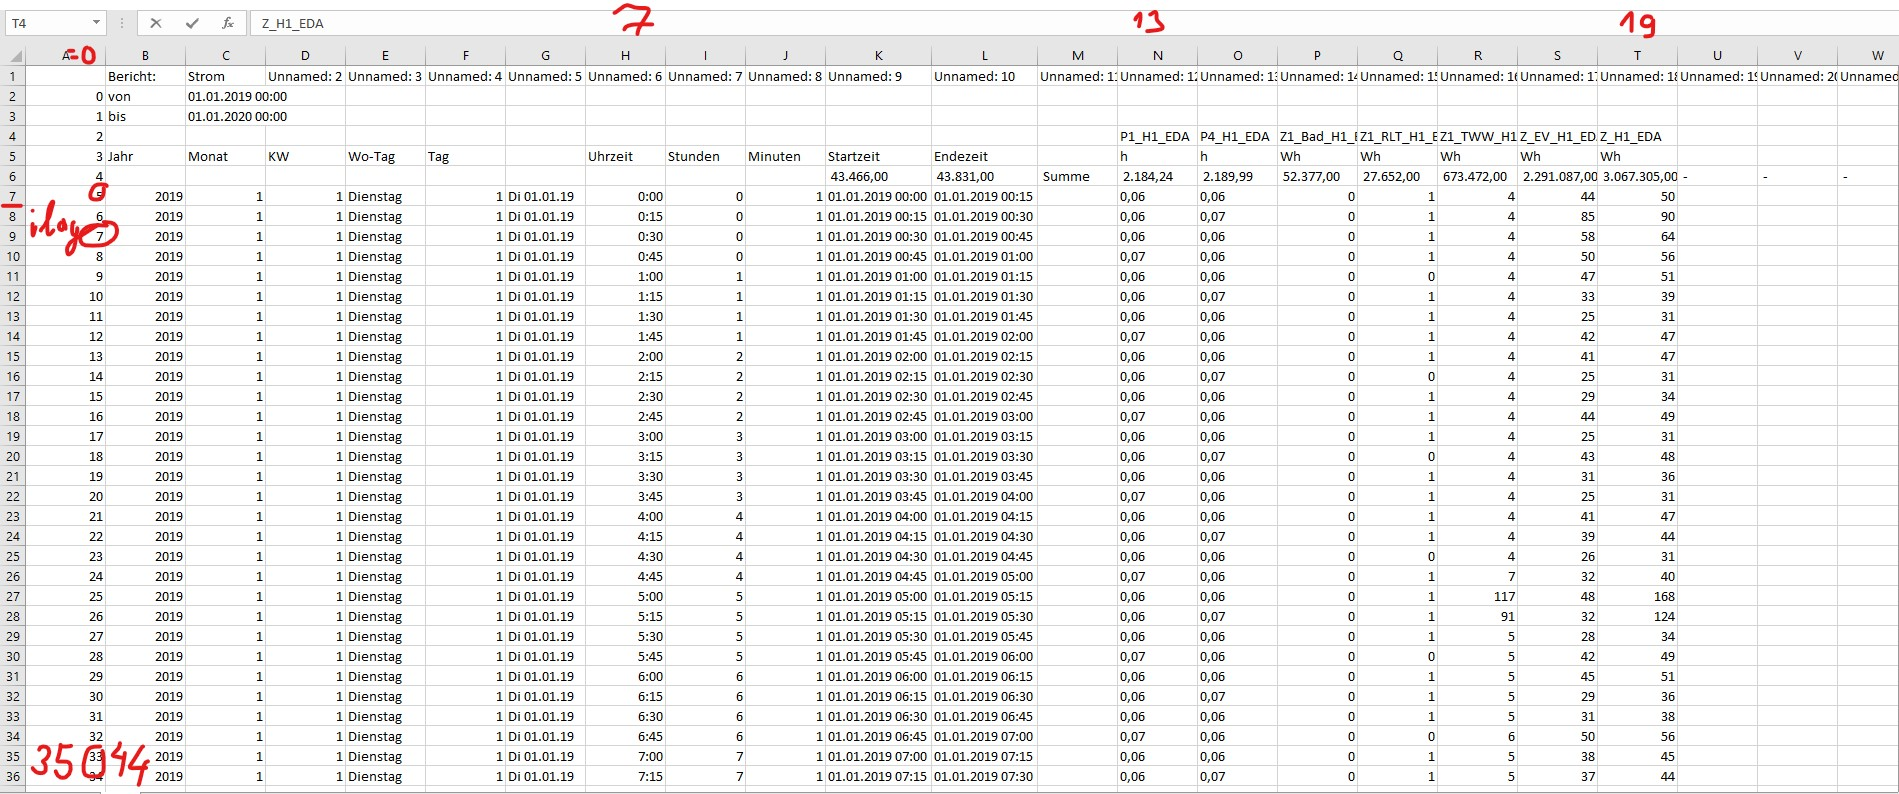

```python
test = data.iloc[5:101,13:20] #row 5 to 100 (equivalent day 1), column 13 to 19
pumpe1    = data.iloc[5:101,13]
pumpe4    = data.iloc[5:101,14]
heizstrom = data.iloc[5:101,15]
ventilator= data.iloc[5:101,16]
TWWP      = data.iloc[5:101,17]
el_Ver    = data.iloc[5:101,18]
Hauptzähler    = data.iloc[5:101,19]

time      = data.iloc[5:101,7]
```

```python

    '''
    P1_EDA = get_data_from_table(day,offsetRow,timestampPerDay,13,dataframe)
    row.extend(P1_EDA)
    P4_EDA = get_data_from_table(day,offsetRow,timestampPerDay,14,dataframe)
    row.extend(P4_EDA)
    Z1_Bad = get_data_from_table(day,offsetRow,timestampPerDay,15,dataframe)
    row.extend(Z1_Bad)
    Z1_RLT = get_data_from_table(day,offsetRow,timestampPerDay,16,dataframe)
    row.extend(Z1_RLT)
    Z1_TWW = get_data_from_table(day,offsetRow,timestampPerDay,17,dataframe)
    row.extend(Z1_TWW)
    EA_EDA = get_data_from_table(day,offsetRow,timestampPerDay,19,dataframe)
    row.extend(EA_EDA)
    '''
    EV_EDA = get_data_from_table(day,offsetRow,timestampPerDay,18,dataframe)
    row.extend(EV_EDA)
    
    
    #now row have all the input data needed (filling up later: label)
    listDataframe.append(row)

```

In [2]:
offsetRow = 5
timestampPerDay = 96
offsetCol = 4
t = range(0,96) #for time axes 

def convertCommaDot(s):
    return float(s.replace(',','.'))

def get_data_from_table(day,offset,timestampPerDay,columnNr,dataframe):
    data = dataframe.iloc[offset+day*timestampPerDay:(timestampPerDay+offset)+day*timestampPerDay,columnNr] #Data type = pandas.Series of string
    #data = list(map(convertCommaDot, data))
    return data

#fill up listDataframe with the data in csvFilename
#input 
# listDataframe: Dataframe with type list (start with empty list)
# csvFilename: name of csv_data
def read_csv(listDataframe, csvFilename):
    dataframe = pd.read_csv(csvFilename, delimiter=',', low_memory=False)
    numberOfDays=int((dataframe.shape[0]-offsetRow)/timestampPerDay)
    weekday = dataframe.iloc[offsetRow+0*timestampPerDay,4]
    summertimeOffset = 0
    for day in range(numberOfDays):
        # 1.part: important information: day in year, weekday, date 
        date = dataframe.iloc[offsetRow+day*timestampPerDay,6] #(to read, not an input for model)
        
        weekday = dataframe.iloc[offsetRow+day*timestampPerDay,4]
        weekday = weekdayDict[weekday]                    #change to int for input in model
        row = [date, day, weekday]                        #day 0 -> 364 / 365
        
        if date in summertimeDate and day < 180:
            print("summer time start")
            print(date)
            summertimeOffset = -4 #get data from last hour the day before
            
        if date in summertimeDate and day > 180:
            print("winter time start")
            print(date)
            summertimeOffset = 0  #ignore data from 1st hour of the day
            
        EV_EDA = get_data_from_table(day,offsetRow + summertimeOffset,timestampPerDay,18,dataframe)
        row.extend(EV_EDA)


        #now row have all the input data needed (filling up later: label)
        listDataframe.append(row)
        
#input:
# csvFile: list of csv_data to read 
# csvOutput: filename of csv output

def prepare_data(listCsvFile, csvOutput):
    listDataframe = [] #init an empty list
    
    for csvFilename in listCsvFile:
        read_csv(listDataframe, csvFilename)

    #transform list to df and write to new csv data
    df = pd.DataFrame(listDataframe)        
    #write to csv file    
    df.to_csv(csvOutput)

def get_data_from_table_day(line, offsetCol, timestampPerDay, dataframe):
    data = dataframe.iloc[line, offsetCol:(offsetCol + timestampPerDay)]
    data = list(data)
    return data

def plot_full_figure(dataList, date):
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
    ax.plot(t, dataList)
    ax.set_xlabel('Time')
    plt.ylim(0, 300)
    ax.set_xticks([0,11,23,35,47,59,71,83,95])
    ax.set_xticklabels(['00:00','03:00','06:00','09:00','12:00','15:00','18:00','21:00','23:45'])
    title = "Energy using in 24 Hours of Date: " + date
    plt.title(title)
    plt.ylabel("Energy in Wh")
    plt.show()

def average(lst):
    return sum(lst) / len(lst)

def plot_hour(data, time):
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
    ax.set_xlabel('Time')
    ax.set_xticks([0,1,2,3,4,5,6,7])
    ax.set_xticklabels([ str(time) + ':00', str(time) + ':15', str(time) + ':30', str(time) + ':45', 
                         str(time + 1) + ':00', str(time + 1) + ':15', str(time + 1) + ':30', str(time + 1) + ':45'])
    ax.set_ylim([0, 1000])
    plt.plot(data)
    title = "Energy use from {0}:00 to {1}:45".format(time,time+1)
    plt.ylabel("Energy in Wh")
    plt.title(title)
    plt.show()

#Sliding the window function on the array
def window_signal_slide(signal, window_size, step_size):
    # Create a Hamming window
    window = np.hamming(window_size)

    # Initialize a list to store the windowed signal data
    signal_windowed = []
  
    # Iterate through the signal data with a for loop
    for i in range(0, len(signal) - window_size, step_size):
        # Apply the Hamming window to a window of the signal data
        signal_windowed.append(sum(signal[i:i+window_size] * window))
  
    return signal_windowed

#Most appear in the list, else print the 1st (lowest distance)
def most_frequent(List):
    counter = 0
    num = List[0]
    for i in List:
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
    return num

def conf_matrix(confusion_matrix, labels_mapping):
    fig = plt.figure(figsize=(12,12))
    width = np.shape(confusion_matrix)[1]
    height = np.shape(confusion_matrix)[0]

    res = plt.imshow(np.array(confusion_matrix), cmap=plt.cm.summer)
    for i, row in enumerate(confusion_matrix):
        for j, c in enumerate(row):
            if c>0:
                plt.text(j-.2, i+.1, c, fontsize=16)

    cb = fig.colorbar(res)
    plt.title('Confusion Matrix')
    plt.xlabel("Predicted Classes",fontsize=18)
    plt.ylabel("Actual Classes",fontsize=18)
    _ = plt.xticks(range(6), [l for l in labels_mapping.values()], rotation=90,fontsize=14)
    _ = plt.yticks(range(6), [l for l in labels_mapping.values()],fontsize=14)

from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model)
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

In [3]:
offsetRow = 5
timestampPerDay = 96
offsetCol = 4
t = range(0,96) #for time axes 

#dictionary for column number
columnDict = {
    13: "Relais für die Erfassung der Betriebsstunden für Pumpe 1",
    14: "Relais für die Erfassung der Betriebsstunden für Pumpe 4",
    15: "Zähler für el. Heizstrom im Haushalt",
    16: "Zähler für Ventilator im Haushalt",
    17: "Zähler für TWWP im Haushalt (TWWP?)",
    18: "Zähler für elektrischen Verbraucher",
    19: "Hauptzähler",
}

#There are some constant of those csv file


weekdayDict = {
    "Montag": 0,
    "Dienstag": 1,
    "Mittwoch": 2,
    "Donnerstag": 3,
    "Freitag": 4,
    "Samstag": 5,
    "Sonntag": 6,
}
#manual add summer time 
summertimeDate = ("So 31.03.19", "So 27.10.19", "So 29.03.20", "So 25.10.20") #extend later with more data'

# haus = ["H1","H2"]
haus = ["H1","H2","H3","H4","H5"]
# year = ["2019", "2020"]
year = ["2019"]
listCsvFile = []
for h in haus:
    for y in year:
        csvFile = "./{year}_fixed/{haus}.csv".format(year=y, haus=h)
        listCsvFile.append(csvFile)
        
haus_str = "_".join(haus)
csvOutput = haus_str +"_not_GMT.csv"

prepare_data(listCsvFile, csvOutput)

#Manually remove the non data day

summer time start
So 31.03.19
winter time start
So 27.10.19
summer time start
So 31.03.19
winter time start
So 27.10.19
summer time start
So 31.03.19
winter time start
So 27.10.19
summer time start
So 31.03.19
winter time start
So 27.10.19
summer time start
So 31.03.19
winter time start
So 27.10.19


### Not using this code -> remove background energy not work

dataframe = pd.read_csv('./'+ haus +'_not_GMT.csv', delimiter=',', low_memory=False) #dataframe has type pandas.core.frame.dataframeFrame

totalLine = dataframe.shape[0]
timestampPerDay = 96
offsetCol = 4
offsetEnergy = 0 #Wh

def get_data_from_table_1(line, offsetCol, timestampPerDay, dataframe):
    data = dataframe.iloc[line, offsetCol:(offsetCol + timestampPerDay)]
    data = list(data)
    return data

def lowest_sum_4(numbers):
    lowest_sum = float('inf')
    lowest_i = -1
    for i in range(len(numbers) - 3):
        sum = numbers[i] + numbers[i+1] + numbers[i+2] + numbers[i+3]
        if sum < lowest_sum:
            lowest_sum = sum
            lowest_i = i
    #expect the index around 0 -> 20
    return (lowest_sum,lowest_i)

def subtract_list(numbers, x):
    result = []
    for number in numbers:
        result.append(number - x)
    return result

def average(lst):
    return sum(lst) / len(lst)

listDataframe = []
i = 0
for line in range(0,totalLine):
    #plt.clf()
    date = dataframe.iloc[line,1]
    day = dataframe.iloc[line,2]
    
    data = get_data_from_table_1(line, offsetCol, timestampPerDay, dataframe)
    average_consum_energy = average(data)
    average_backConsum_energy, lowest_index = lowest_sum_4(data)
    average_backConsum_energy = average_backConsum_energy/4
    if(lowest_index > 20 and lowest_index < 88 and 
       abs(average_consum_energy - average_backConsum_energy)/average_backConsum_energy > 0.1):
            print(date, lowest_index)

listDataframe = []
i = 0
for line in range(0,totalLine):
    #plt.clf()
    date = dataframe.iloc[line,1]
    day = dataframe.iloc[line,2]
    weekday = dataframe.iloc[line,3]
    data = get_data_from_table_1(line, offsetCol, timestampPerDay, dataframe)
    #label = dataframe.iloc[line,100]
    
    # Not working calculate background consuming
    #average_backConsum_energy, lowest_index = lowest_sum_4(data)
    #average_backConsum_energy = average_backConsum_energy/4
    
    #data = subtract_list(data, average_backConsum_energy - offsetEnergy)
    
    row = [date, day, weekday]
    row.extend(data)          
    #row.append(label)
    row.append(average_backConsum_energy)
    listDataframe.append(row)
    
df = pd.DataFrame(listDataframe) 
df.to_csv(haus + "_ready_classification.csv")
    


## Manual sorting using Matplotlib

<Figure size 576x396 with 0 Axes>

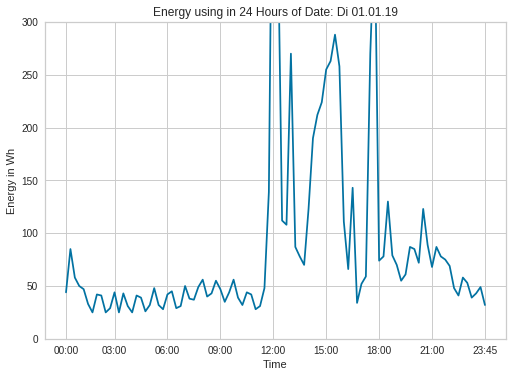

<Figure size 576x396 with 0 Axes>

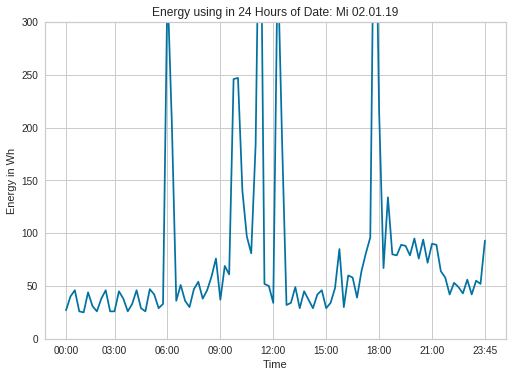

<Figure size 576x396 with 0 Axes>

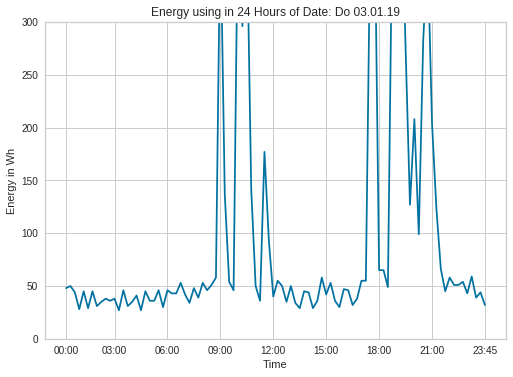

<Figure size 576x396 with 0 Axes>

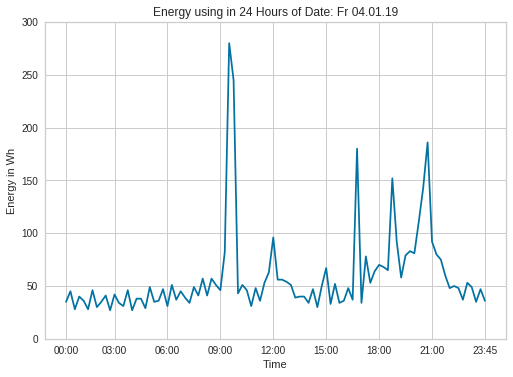

<Figure size 576x396 with 0 Axes>

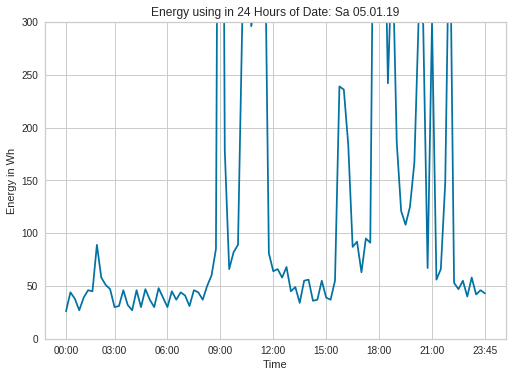

<Figure size 576x396 with 0 Axes>

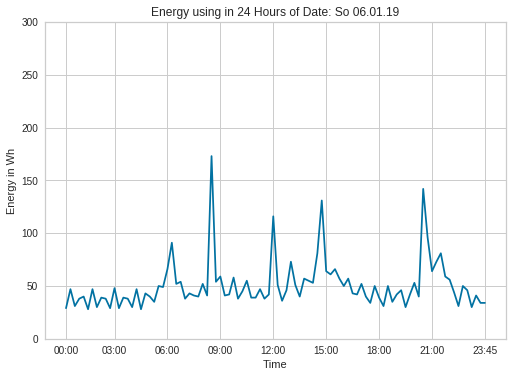

<Figure size 576x396 with 0 Axes>

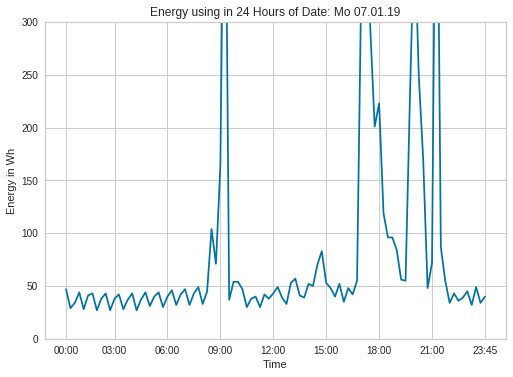

<Figure size 576x396 with 0 Axes>

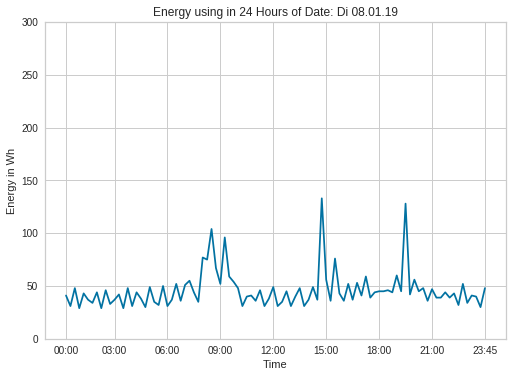

<Figure size 576x396 with 0 Axes>

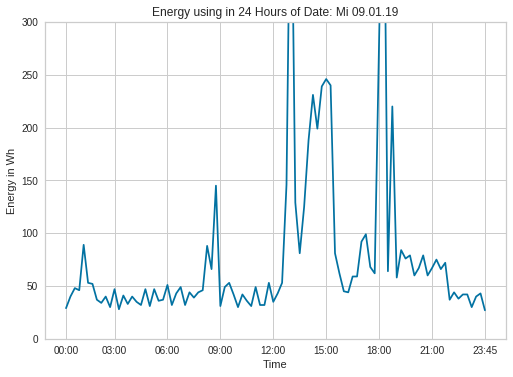

<Figure size 576x396 with 0 Axes>

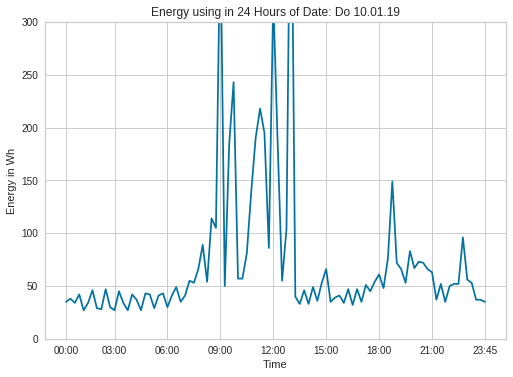

<Figure size 576x396 with 0 Axes>

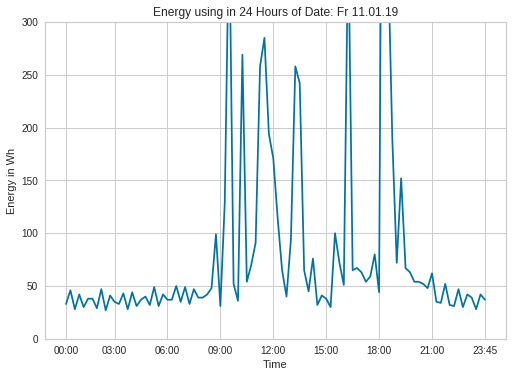

<Figure size 576x396 with 0 Axes>

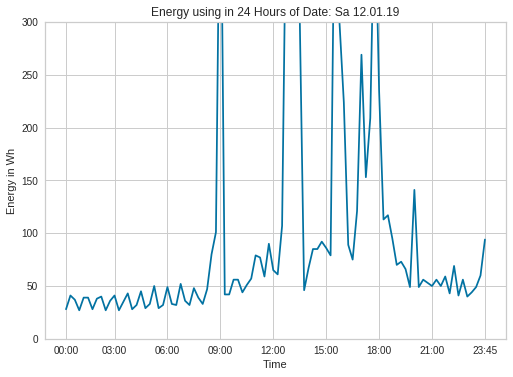

<Figure size 576x396 with 0 Axes>

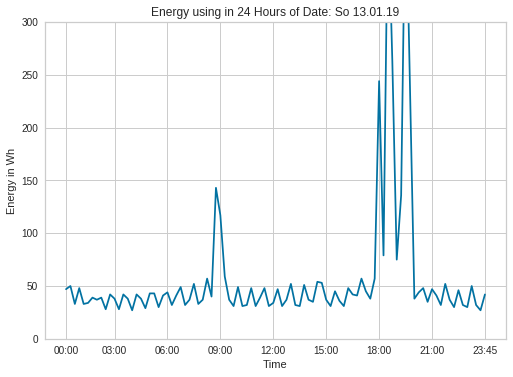

<Figure size 576x396 with 0 Axes>

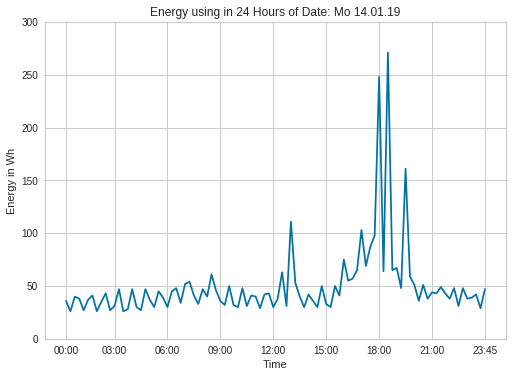

<Figure size 576x396 with 0 Axes>

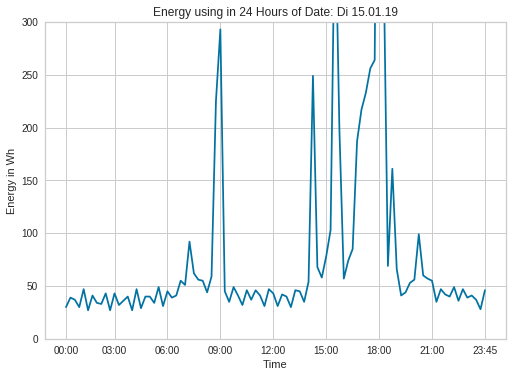

<Figure size 576x396 with 0 Axes>

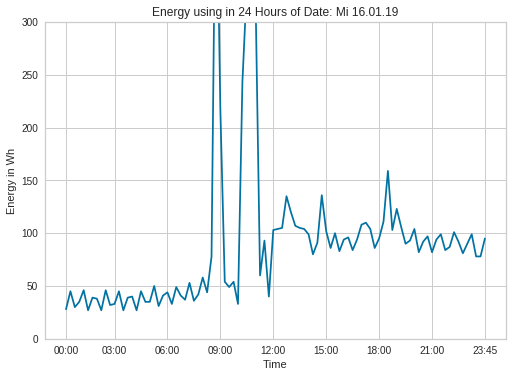

<Figure size 576x396 with 0 Axes>

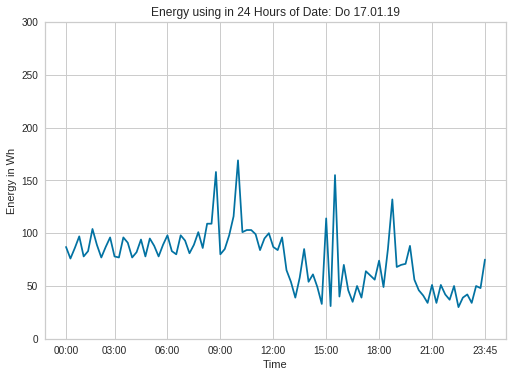

<Figure size 576x396 with 0 Axes>

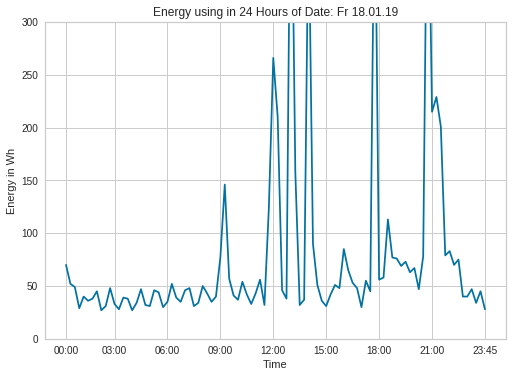

<Figure size 576x396 with 0 Axes>

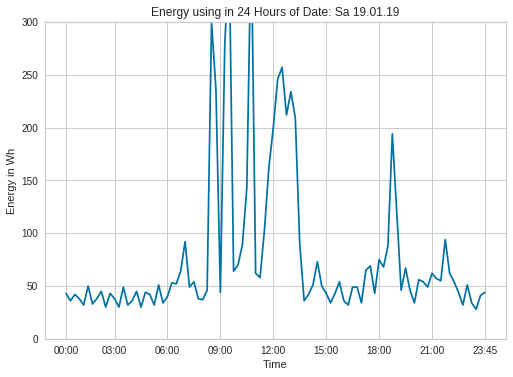

<Figure size 576x396 with 0 Axes>

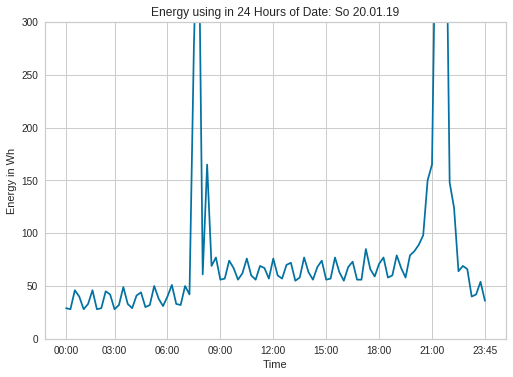

<Figure size 576x396 with 0 Axes>

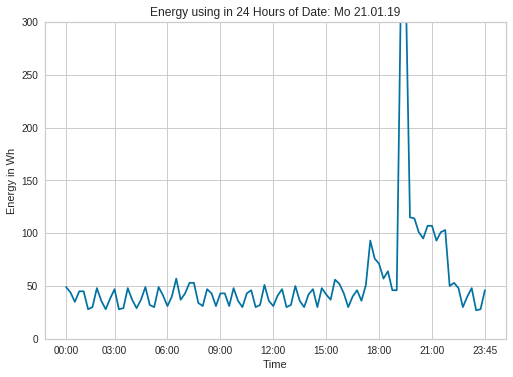

<Figure size 576x396 with 0 Axes>

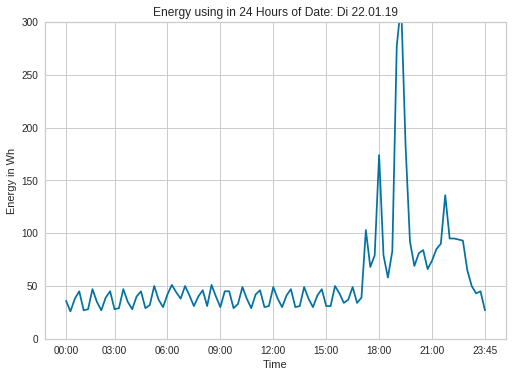

<Figure size 576x396 with 0 Axes>

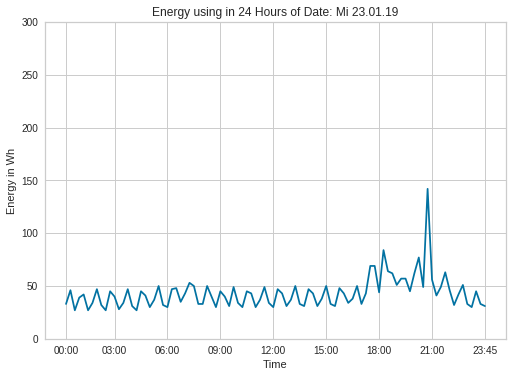

<Figure size 576x396 with 0 Axes>

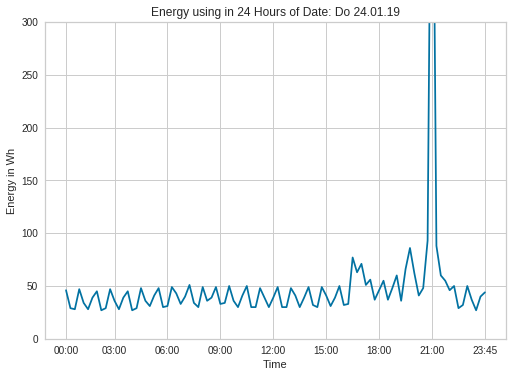

<Figure size 576x396 with 0 Axes>

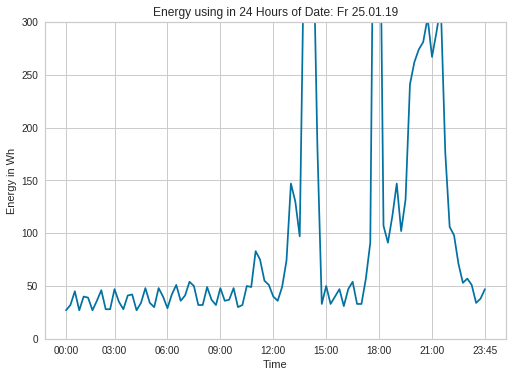

<Figure size 576x396 with 0 Axes>

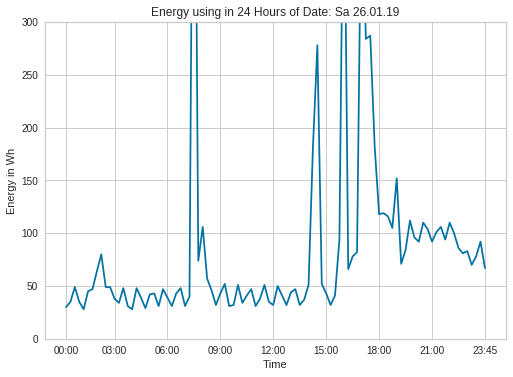

<Figure size 576x396 with 0 Axes>

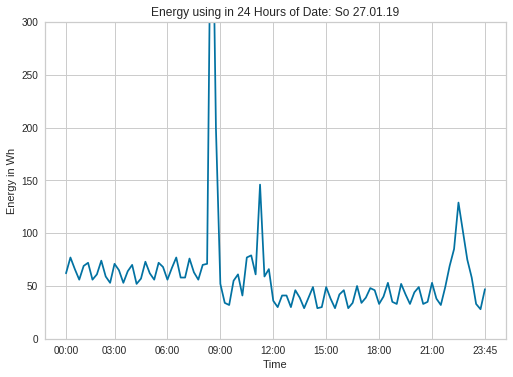

<Figure size 576x396 with 0 Axes>

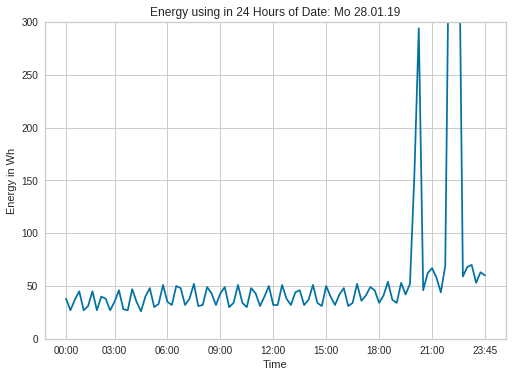

<Figure size 576x396 with 0 Axes>

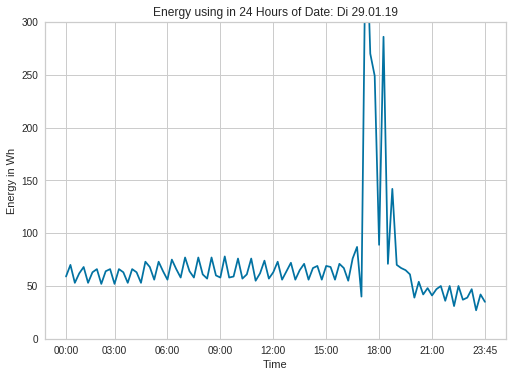

<Figure size 576x396 with 0 Axes>

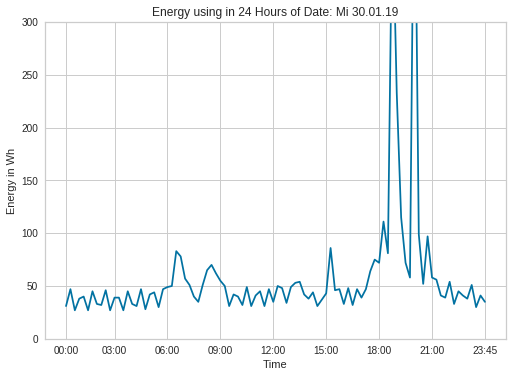

In [4]:
#Plot

dataframe = pd.read_csv('./' + csvOutput, delimiter=',', low_memory=False)
for line in range(0,30):
    plt.clf()
    date = dataframe.iloc[line,1]
    day = dataframe.iloc[line,2]
    
    data = get_data_from_table_day(line, offsetCol, timestampPerDay, dataframe)
    plot_full_figure(data, date)
    

## Dynamic Time Warping to auto Labeling (Good accuracy but cost lot of time to run)

DTW bases on the pattern (cannot use pattern from house of 2 people to classification house of 5 people)

In [5]:
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [6]:
labels_mapping = { 
                    0: "not at home",
                    1: "early leaving",
                    2: "comeback",
                    3: "working / outgoing",
                    4: "at home",
                    5: "mix" 
                  }

# Parameter for dynamic time warping function
window_size = 12
step_size = 2
dtw_win_size = 2
number_of_votes = 5
big_int = 100000

#non label data
allDataFrame = pd.read_csv('./' + csvOutput, delimiter=',', low_memory=False)
#handlabel
labelDataFrame = pd.read_csv('./H1_label.csv', delimiter=',', low_memory=False)

In [7]:
# This block create a csv data, which is label with DTW
kNN_list = []
classifcation_list = []
rowToRemove = []
totalRow = allDataFrame.shape[0]

for line in range(0,totalRow):
    data = get_data_from_table_day(line, offsetCol, timestampPerDay, allDataFrame) #Nonlabel data
    data = window_signal_slide(data, window_size , step_size)

    Voting_list = []
    for i in range(number_of_votes):
        Voting_list.append((big_int,0))
    try:
        for label_line in range(0,365):
            #skip the same pattern
            if label_line == line:
                continue
            pattern_data = get_data_from_table_day(label_line, offsetCol, timestampPerDay, labelDataFrame) #label data
            pattern_label = labelDataFrame.iloc[label_line, 100]
            pattern_data = window_signal_slide(pattern_data, window_size , step_size)
            distance = dtw(pattern_data,data,keep_internals=True,window_type = "sakoechiba", window_args = {'window_size':dtw_win_size}).distance
            #get 5 lowest distance and their labels
            for i in range (number_of_votes):
                if distance < Voting_list[i][0]:
                    Voting_list.insert(i,(distance,pattern_label))
                    Voting_list.pop()
                    break


            nearest_neighbor_set = []
            #Voting with k nearest neighbor
            for i in range(number_of_votes):
                nearest_neighbor_set.append(Voting_list[i][1])
            classifcation_label = most_frequent(nearest_neighbor_set)
    #Catching error and remove it out of data frame
    except ValueError:
        #Remove a row in dataframe -> read row again with new data
        #can also add row to a list and remove at once later
        rowToRemove.append(line)
        print("Error")
        continue
#         nearest_neighbor_set = ["Error data"]
#         classifcation_label = "Error"
#     #To check with manual label
#     true_label = labelDataFrame.iloc[line, 100]
#     print(nearest_neighbor_set, classifcation_label, true_label)
#     if line < 365:
#         true_label = labelDataFrame.iloc[line, 100]
#         print(line, nearest_neighbor_set, classifcation_label, true_label) #<- only use this when check H1_2019
#     else:
#         print(line, nearest_neighbor_set, classifcation_label)
    print(line, nearest_neighbor_set, classifcation_label)
    kNN_list.append(nearest_neighbor_set)
    classifcation_list.append(classifcation_label)
    
    
allDataFrame.drop(index=rowToRemove, inplace=True)
allDataFrame.drop(columns="Unnamed: 0", inplace=True)
allDataFrame.insert(99,"kNN list", kNN_list)
allDataFrame.insert(100,"classification label", classifcation_list)

dtw_csv = "{house}_DTW_label_ws_{window_size}_ss_{step_size}_dtwws_{dtw_win_size}_NoV_{number_of_votes}.csv".format(
            house = haus_str, window_size = window_size, step_size = step_size, 
            dtw_win_size = dtw_win_size, number_of_votes = number_of_votes)
allDataFrame.to_csv(dtw_csv)           
        

0 [4, 4, 4, 4, 4] 4
1 [4, 3, 4, 5, 5] 4
2 [4, 3, 4, 4, 4] 4
3 [4, 5, 3, 5, 5] 5
4 [4, 4, 4, 4, 4] 4
5 [5, 4, 4, 4, 3] 4
6 [5, 4, 5, 3, 4] 5
7 [3, 3, 1, 3, 4] 3
8 [4, 4, 4, 4, 4] 4
9 [5, 4, 4, 4, 5] 4
10 [4, 4, 4, 5, 4] 4
11 [4, 4, 4, 4, 4] 4
12 [3, 3, 3, 3, 3] 3
13 [4, 2, 3, 5, 3] 3
14 [3, 4, 4, 3, 3] 3
15 [4, 3, 4, 3, 4] 4
16 [1, 4, 5, 4, 5] 4
17 [5, 4, 4, 5, 4] 4
18 [4, 5, 3, 4, 4] 4
19 [4, 4, 4, 5, 5] 4
20 [2, 5, 3, 2, 5] 2
21 [2, 5, 5, 3, 3] 5
22 [3, 2, 3, 3, 3] 3
23 [2, 2, 2, 3, 3] 2
24 [2, 4, 2, 5, 3] 2
25 [3, 3, 3, 4, 3] 3
26 [5, 1, 3, 4, 5] 5
27 [2, 3, 5, 5, 2] 2
28 [3, 4, 4, 5, 4] 4
29 [3, 2, 3, 3, 3] 3
30 [4, 5, 4, 4, 4] 4
31 [5, 4, 5, 5, 5] 5
32 [1, 3, 1, 4, 3] 1
33 [5, 4, 4, 5, 5] 5
34 [3, 3, 3, 5, 2] 3
35 [5, 5, 4, 4, 3] 5
36 [3, 2, 5, 3, 3] 3
37 [3, 4, 4, 3, 3] 3
38 [5, 4, 3, 4, 4] 4
39 [4, 4, 4, 4, 4] 4
40 [4, 4, 5, 4, 4] 4
41 [2, 5, 3, 2, 3] 2
42 [3, 5, 2, 4, 3] 3
43 [3, 3, 2, 5, 2] 3
44 [1, 1, 0, 1, 0] 1
45 [0, 0, 0, 0, 0] 0
46 [0, 0, 0, 0, 0] 0
47 [0, 3, 0, 0, 0] 0
48

KeyboardInterrupt: 

0.8191780821917808
                    precision    recall  f1-score   support

       not at home       0.80      1.00      0.89        33
     early leaving       1.00      0.58      0.74        12
          comeback       0.87      0.68      0.76        19
working / outgoing       0.77      0.83      0.80        76
           at home       0.86      0.91      0.89       183
               mix       0.62      0.38      0.47        42

          accuracy                           0.82       365
         macro avg       0.82      0.73      0.76       365
      weighted avg       0.81      0.82      0.81       365



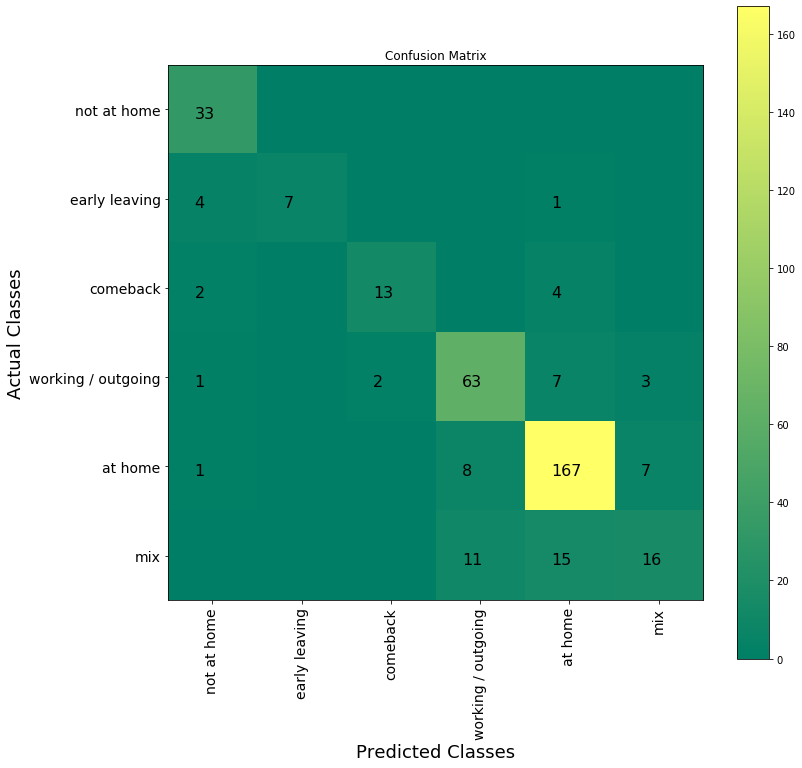

In [94]:
#Check Accuracy of DTW
import sklearn
from sklearn import metrics

DTW_label_dataframe = pd.read_csv('./'+ dtw_csv, delimiter=',', low_memory=False)

DTW_data = DTW_label_dataframe.loc[0:364,"classification label"].astype(int)
#DTW_data = DTW_data.tolist()
manual_data = labelDataFrame.loc[0:364,"manual label"].astype(int)
#manual_data = manual_data.tolist()
confusion_matrix = sklearn.metrics.confusion_matrix(y_true=manual_data, y_pred=DTW_data)

print(sklearn.metrics.accuracy_score(y_true = manual_data, y_pred=DTW_data))
print(sklearn.metrics.classification_report(y_true=manual_data, y_pred=DTW_data, 
                                               target_names= [l for l in labels_mapping.values()]))
#Change DTW parameter -> change DTW accuracy
conf_matrix(confusion_matrix=confusion_matrix, labels_mapping=labels_mapping)

## Using DTW auto labeling data to train

/home/manhlinhphan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/manhlinhphan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/manhlinhphan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.7178082191780822
                    precision    recall  f1-score   support

       not at home       0.77      1.00      0.87        33
     early leaving       1.00      0.42      0.59        12
          comeback       0.75      0.32      0.44        19
working / outgoing       0.57      0.72      0.64        76
           at home       0.77      0.89      0.83       183
               mix       0.00      0.00      0.00        42

          accuracy                           0.72       365
         macro avg       0.64      0.56      0.56       365
      weighted avg       0.64      0.72      0.67       365



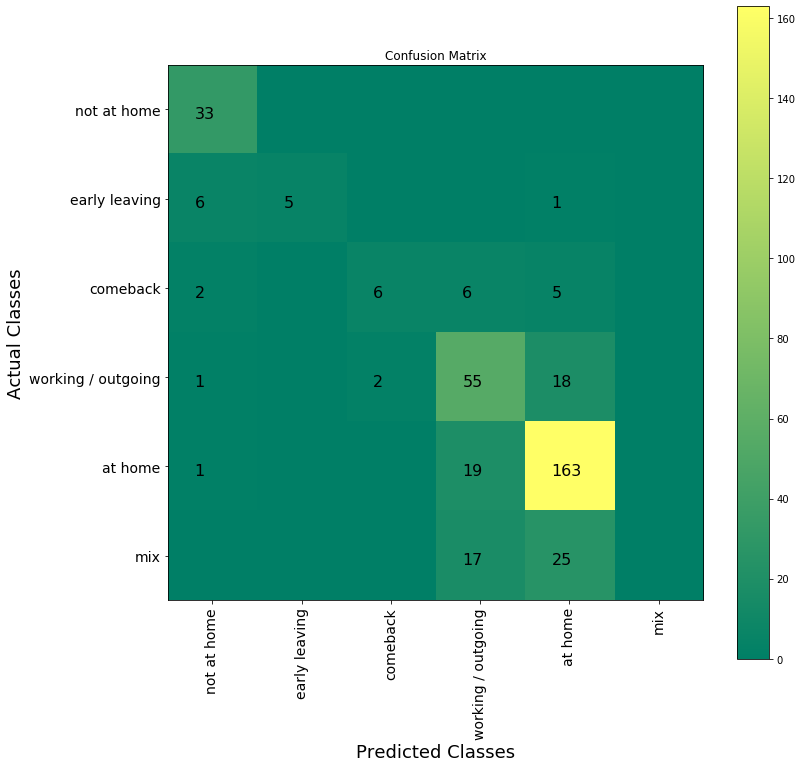

In [93]:

labels_mapping = { 
                    0: "not at home",
                    1: "early leaving",
                    2: "comeback",
                    3: "working / outgoing",
                    4: "at home",
                    5: "mix" 
                 }

from sktime.classification.interval_based import TimeSeriesForestClassifier
from sklearn.model_selection import train_test_split

datasets = pd.read_csv("./"+dtw_csv)

features = datasets.iloc[0:datasets.shape[0], list(range(offsetCol,offsetCol+timestampPerDay))].values
labels = datasets.iloc[0:datasets.shape[0], 101].values
#Using train split test function
# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.3, random_state = 30)

#Here to choose how the feature and label are divided
X_train = features[365:datasets.shape[0]]
y_train = labels[365:datasets.shape[0]]
X_test = features[0:365]
y_test = labels[0:365]

# scaler = MinMaxScaler()   

# X_train = scaler.fit_transform(X_train)  
# X_test = scaler.transform(X_test) 

classifier = TimeSeriesForestClassifier(n_estimators=100, random_state= 1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
# # Compare with the labeled from DTW
# accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
# confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
# report = sklearn.metrics.classification_report(y_test, y_pred, 
#                                                target_names= [l for l in labels_mapping.values()])

# Compare with the manual label -> lower accuracy (1st through DTW, 2nd through TSFC)
accuracy = sklearn.metrics.accuracy_score(y_true = manual_data, y_pred=y_pred)
confusion_matrix = sklearn.metrics.confusion_matrix(y_true = manual_data, y_pred=y_pred)
report = sklearn.metrics.classification_report(y_true = manual_data, y_pred= y_pred, 
                                               target_names= [l for l in labels_mapping.values()])

print(accuracy)
print(report)
conf_matrix(confusion_matrix=confusion_matrix, labels_mapping=labels_mapping)

### Class 0

#### TP: Matrix[0,0]

The actual value and predicted value should be the same. So concerning Setosa class, the value of cell 1 is the TP value.

#### FN: Matrix[0,1:5]

The sum of values of corresponding rows except the TP value

#### FP: Matrix[1:5,0]

The sum of values of corresponding column except the TP value.

#### TN : Matrix[1:5,1:5]

The sum of values of all columns and row except the values of that class that we are calculating the values for.

/home/manhlinhphan/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/manhlinhphan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/manhlinhphan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/manhlinhphan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/manhlinhphan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/manhlinhphan/.local/lib/python3.8/site-packages/sktime/utils/slope_and_trend.py:80: Runtime

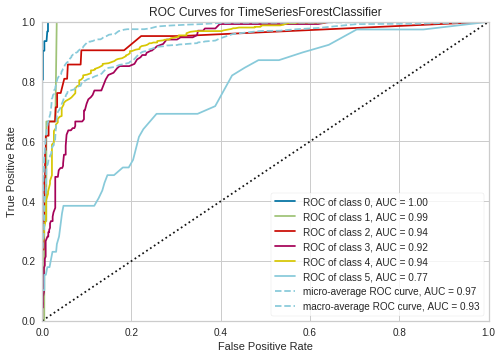

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ba9aa54f0>,
       estimator=TimeSeriesForestClassifier())

In [56]:
plot_ROC_curve(classifier, X_train, y_train, X_test, y_test)

# Install a pip package in the current Jupyter kernel

```python
import sys
!{sys.executable} -m pip install {module}
```

/home/manhlinhphan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/manhlinhphan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/manhlinhphan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.7726027397260274
                    precision    recall  f1-score   support

       not at home       0.79      0.93      0.85        41
     early leaving       0.00      0.00      0.00         7
          comeback       0.46      0.40      0.43        15
working / outgoing       0.64      0.74      0.69        82
           at home       0.86      0.91      0.89       194
               mix       0.00      0.00      0.00        26

          accuracy                           0.77       365
         macro avg       0.46      0.50      0.48       365
      weighted avg       0.71      0.77      0.74       365



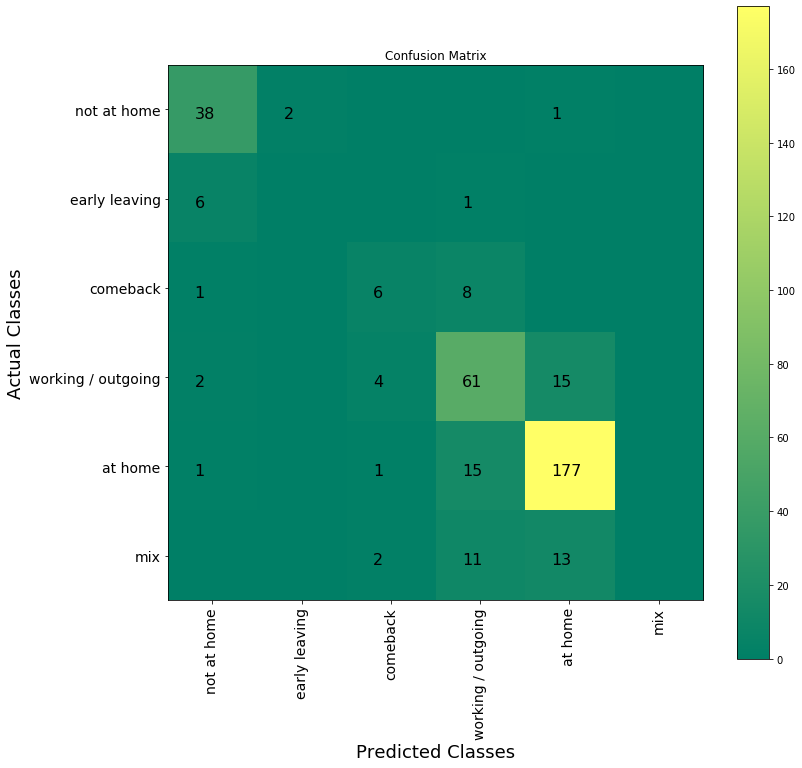

In [96]:
labels_mapping = { 0: "not at home",
                  1: "early leaving",
                2: "comeback",
                3: "working / outgoing",
                4: "at home",
                5: "mix" 
                 }
from sklearn.preprocessing import MinMaxScaler  
from sktime.classification.interval_based import SupervisedTimeSeriesForest
from sklearn.model_selection import train_test_split

datasets = pd.read_csv("./"+dtw_csv)

features = datasets.iloc[0:datasets.shape[0], list(range(offsetCol,offsetCol+timestampPerDay))].values
labels = datasets.iloc[0:datasets.shape[0], 101].values
#Using train split test function
# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.3, random_state = 30)

#Here to choose how the feature and label are divided
X_train = features[365:datasets.shape[0]]
y_train = labels[365:datasets.shape[0]]
X_test = features[0:365]
y_test = labels[0:365]

# scaler = MinMaxScaler()   

# X_train = scaler.fit_transform(X_train)  
# X_test = scaler.transform(X_test) 

classifier = SupervisedTimeSeriesForest()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
# Compare with the labeled from DTW
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
report = sklearn.metrics.classification_report(y_test, y_pred, 
                                               target_names= [l for l in labels_mapping.values()])

# # Compare with the manual label -> lower accuracy (1st through DTW, 2nd through classifier)
# accuracy = sklearn.metrics.accuracy_score(y_true = manual_data, y_pred=y_pred)
# confusion_matrix = sklearn.metrics.confusion_matrix(y_true = manual_data, y_pred=y_pred)
# report = sklearn.metrics.classification_report(y_true = manual_data, y_pred= y_pred, 
#                                                target_names= [l for l in labels_mapping.values()])

print(accuracy)
print(report)
conf_matrix(confusion_matrix=confusion_matrix, labels_mapping=labels_mapping)


/home/manhlinhphan/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/manhlinhphan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/manhlinhphan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/manhlinhphan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/manhlinhphan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/manhlinhphan/.local/lib/python3.8/site-packages/sktime/utils/slope_and_trend.py:80: Runtime

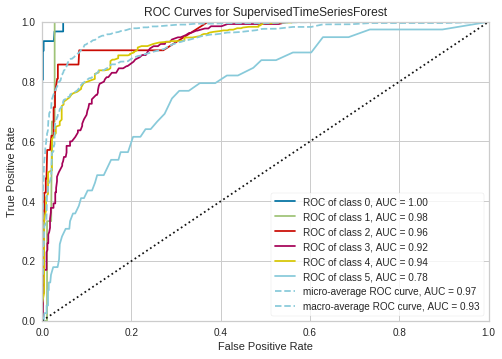

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b945fb040>,
       estimator=SupervisedTimeSeriesForest())

In [66]:
plot_ROC_curve(classifier, X_train, y_train, X_test, y_test)